In [10]:
%pip install -r ./requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip uninstall torch torchvision -y
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

Found existing installation: torch 2.6.0+cpu
Uninstalling torch-2.6.0+cpu:
  Successfully uninstalled torch-2.6.0+cpu
Found existing installation: torchvision 0.21.0+cpu
Uninstalling torchvision-0.21.0+cpu:
  Successfully uninstalled torchvision-0.21.0+cpu
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.6.0%2Bcpu-cp310-cp310-linux_x86_64.whl (178.6 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.21.0%2Bcpu-cp310-cp310-linux_x86_64.whl (1.8 MB)
Note: you may need to restart the kernel to use updated packages.


# Data Preparation
In this step, I will be using the `datasets` python library to load both the image and mask together to make it easier for downstream tasks to process the data.
<br>

Once the dataset can be loaded, image augmentation will be performed with the `albumentations` python library to ensure the image size is consistent and our training data is robust.

## Data Loading

In [12]:
import os
from datasets import Dataset, Features, Image
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
import random

random.seed(42)

In [13]:
def data_to_dict(split_path):
    images = []
    masks = []
    color_dir = os.path.join(split_path, 'color')
    label_dir = os.path.join(split_path, 'label')
    
    # Sort to ensure the pairing order is consistent
    for fname in sorted(os.listdir(color_dir)):
        image_path = os.path.join(color_dir, fname)
        mask_fname = fname.replace("jpg", "png")
        mask_path = os.path.join(label_dir, mask_fname)
        
        images.append(image_path)
        masks.append(mask_path)
        
    return {"image": images, "mask": masks}


In [14]:
features = Features({
    "image": Image(mode="RGB"),
    "mask": Image(mode="RGB")
})

train_val_data = data_to_dict("Dataset/TrainVal")
test_data = data_to_dict("Dataset/Test")

train_val_dataset = Dataset.from_dict(train_val_data, features=features)
test_dataset = Dataset.from_dict(test_data, features=features)

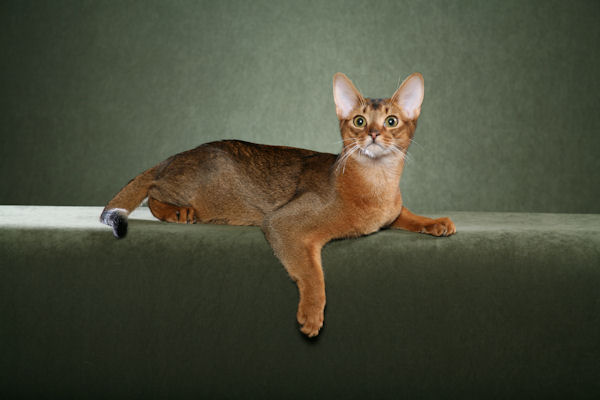

In [15]:
# check dataset is properly loaded
train_val_dataset[0]["image"]

## Image Augmentations
Based on this [guide](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), since the models tend to receive a fixed size tensor, there are a few ways to achieve this.
- Resizing
- Cropping & Padding
<br />

The former way is straight forward but can lead to a loss in image quality, while the latter way is a good balance without compromising the image quality. As part of the first iteration, I will use the resizing augmentation.

In [16]:
import albumentations as A

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    # A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, pad_if_needed=True), # larger images are cropped
    A.Rotate(limit=(-40,40)),
    A.ColorJitter()                       
], strict=True) # 
 


In [17]:
def get_apply_transform_fn(augmentation):
    def apply_transform(data):
        image = np.array(data["image"])
        mask = np.array(data["mask"])
        augmented = augmentation(image=image, mask=mask)
        data["image"] = pil.Image.fromarray(augmented["image"])
        data["mask"] = pil.Image.fromarray(augmented["mask"])
        return data
    return apply_transform

aug_transform_fn = get_apply_transform_fn(transform)
aug_train_val_dataset = train_val_dataset.map(aug_transform_fn)


Map:   0%|          | 0/3680 [00:00<?, ? examples/s]

Map: 100%|██████████| 3680/3680 [00:32<00:00, 112.53 examples/s]


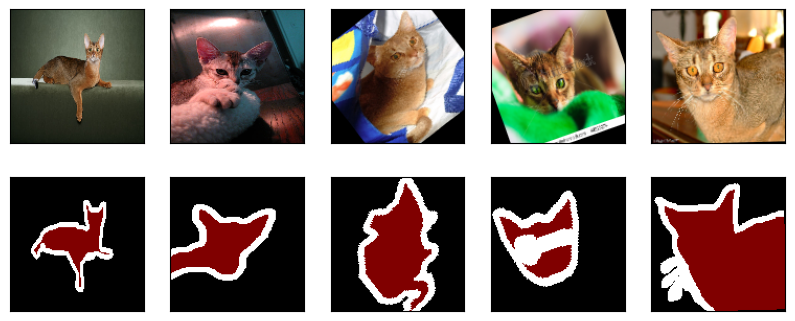

In [18]:
# visualize the transform images
def visualize_transform_images(max, dataset):
    plt.figure(figsize=(10, 4))
    for idx in range(max):
        plt.subplot(2,5,idx+1)
        fig = plt.imshow(dataset[idx]["image"])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    for idx in range(max):
        plt.subplot(2,5,idx+1+5)
        fig = plt.imshow(dataset[idx]["mask"])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

visualize_transform_images(5, aug_train_val_dataset)

In [ ]:
# convert the dataset to tensors
# aug_train_val_dataset.set_format("torch", columns=["image", "mask"])
# test_dataset.set_format("torch", columns=["image", "mask"])
# print(test_dataset[0]["image"])

tensor([[[38, 37, 34,  ..., 30, 30, 30],
         [38, 37, 36,  ..., 31, 30, 30],
         [37, 37, 37,  ..., 31, 30, 30],
         ...,
         [38, 39, 40,  ..., 41, 40, 37],
         [35, 36, 38,  ..., 40, 38, 34],
         [38, 37, 36,  ..., 35, 36, 37]],

        [[36, 35, 32,  ..., 28, 28, 28],
         [36, 35, 34,  ..., 29, 28, 28],
         [35, 35, 35,  ..., 29, 28, 28],
         ...,
         [38, 39, 40,  ..., 40, 39, 36],
         [35, 36, 38,  ..., 39, 37, 33],
         [38, 37, 36,  ..., 33, 34, 35]],

        [[41, 40, 37,  ..., 31, 31, 31],
         [41, 40, 39,  ..., 32, 31, 31],
         [40, 40, 40,  ..., 32, 31, 31],
         ...,
         [46, 47, 48,  ..., 46, 45, 42],
         [43, 44, 46,  ..., 45, 43, 39],
         [46, 45, 44,  ..., 38, 39, 40]]], dtype=torch.uint8)


In [20]:
# split the datasets
train_val_dataset = aug_train_val_dataset.train_test_split(test_size=0.2)
train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]


In [21]:
import pickle as pkl

# save the dataset into a pickle file to be loaded in
with open("processed_dataset/train.pkl", "wb") as f:
    pkl.dump(train_dataset, f)

with open("processed_dataset/val.pkl", "wb") as f:
    pkl.dump(val_dataset, f)

with open("processed_dataset/test.pkl", "wb") as f:
    pkl.dump(test_dataset, f)

In [22]:
# CLIP Model
from transformers import CLIPImageProcessor, CLIPVisionModel

model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [ ]:
image = test_dataset[0]["image"]

CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
    